# Importing

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import sys
from multiprocessing import cpu_count
import copy
import pickle
import warnings
from datetime import datetime, timedelta
from time import time, sleep, mktime
from matplotlib import font_manager as fm, rc, rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import random as rnd

import numpy as np
from numpy import array, nan, where
import pandas as pd
from pandas import DataFrame as dataframe, Series as series, isna, read_csv
from pandas.tseries.offsets import DateOffset
import statsmodels.api as sm
from scipy.stats import f_oneway

from sklearn import preprocessing as prep
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split as tts, GridSearchCV as GridTuner, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from sklearn.pipeline import make_pipeline

from sklearn import linear_model as lm
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn import neighbors as knn
from sklearn import ensemble
from sklearn.preprocessing import KBinsDiscretizer

# display setting
rcParams['axes.unicode_minus'] = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["WANDB_API_KEY"] = "6f810b088fcc6b9eaaa56c1e52cfd37836606240"

# ===== tensorflow =====
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import metrics as tf_metrics
from tensorflow.keras import callbacks as tf_callbacks
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa
import keras_tuner as kt
from keras_tuner import HyperModel
import tensorflow_hub as tf_hub
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

!pip install --upgrade wandb
import wandb
from wandb.keras import WandbCallback

import shutil
# GPU check
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     |████████████████████████████████| 1.7 MB 2.3 MB/s 
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.2
    Uninstalling wandb-0.12.2:
      Successfully uninstalled wandb-0.12.2
Found GPU at: /device:GPU:0


# Utility functions

In [2]:
def seed_everything(seed=42):
    rnd.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
def which(bool_list):
    idx_array = where(bool_list)[0]
    return idx_array[0] if len(idx_array) == 1 else idx_array
def easyIO(x=None, path=None, op="r"):
    tmp = None
    if op == "r":
        with open(path, "rb") as f:
            tmp = pickle.load(f)
        return tmp
    elif op == "w":
        tmp = {}
        print(x)
        if type(x) is dict:
            for k in x.keys():
                if "MLP" in k:
                    tmp[k] = {}
                    for model_comps in x[k].keys():
                        if model_comps != "model":
                            tmp[k][model_comps] = copy.deepcopy(x[k][model_comps])
                    print(F"INFO : {k} model is removed (keras)")
                else:
                    tmp[k] = x[k]
        if input("Write [y / n]: ") == "y":
            with open(path, "wb") as f:
                pickle.dump(tmp, f)
            print("operation success")
        else:
            print("operation fail")
    else:
        print("Unknown operation type")
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]
def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]
def orderElems(for_order, using_ref):
    return [i for i in using_ref if i in for_order]
# concatenate by row
def ccb(df1, df2):
    if type(df1) == series:
        tmp_concat = series(pd.concat([dataframe(df1), dataframe(df2)], axis=0, ignore_index=True).iloc[:,0])
        tmp_concat.reset_index(drop=True, inplace=True)
    elif type(df1) == dataframe:
        tmp_concat = pd.concat([df1, df2], axis=0, ignore_index=True)
        tmp_concat.reset_index(drop=True, inplace=True)
    elif type(df1) == np.ndarray:
        tmp_concat = np.concatenate([df1, df2], axis=0)
    else:
        print("Unknown Type: return 1st argument")
        tmp_concat = df1
    return tmp_concat
def change_width(ax, new_value):
    for patch in ax.patches :
        current_width = patch.get_width()
        adj_value = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + adj_value * .5)
def week_of_month(date):
    month = date.month
    week = 0
    while date.month == month:
        week += 1
        date -= timedelta(days=7)
    return week
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
def softmax(x):
    max = np.max(x, axis=1, keepdims=True)  # returns max of each row and keeps same dims
    e_x = np.exp(x - max)  # subtracts each row with its max value
    sum = np.sum(e_x, axis=1, keepdims=True)  # returns sum of each row and keeps same dims
    f_x = e_x / sum
    return f_x
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def dispPerformance(result_dic):
    perf_table = dataframe()
    index_names = []
    for k, v in result_dic.items():
        index_names.append(k)
        perf_table = pd.concat([perf_table, series(v["performance"]).to_frame().T], ignore_index=True, axis=0)
    perf_table.index = index_names
    perf_table.sort_values(perf_table.columns[0], inplace=True)
    print(perf_table)
    return perf_table
def tf_loss_rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred) ** 2))
class MyLabelEncoder:
    def __init__(self, preset={}):
        # dic_cat format -> {"col_name": {"value": replace}}
        self.dic_cat = preset
    def fit_transform(self, data_x, col_names):
        tmp_x = copy.deepcopy(data_x)
        for i in col_names:
            # type check
            if not ((tmp_x[i].dtype.name == "object") or (tmp_x[i].dtype.name == "category")):
                print(F"WARNING : {i} is not object or category")
            # if key is not in dic, update dic
            if i not in self.dic_cat.keys():
                tmp_dic = dict.fromkeys(sorted(set(tmp_x[i]).difference([nan])))
                label_cnt = 0
                for j in tmp_dic.keys():
                    tmp_dic[j] = label_cnt
                    label_cnt += 1
                self.dic_cat[i] = tmp_dic
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x
    def transform(self, data_x):
        tmp_x = copy.deepcopy(data_x)
        for i in list(self.dic_cat.keys()):
            if not ((tmp_x[i].dtype.name == "object") or (tmp_x[i].dtype.name == "category")):
                print(F"WARNING : {i} is not object or category")
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x
    def clear(self):
        self.dic_cat = {}
class MyOneHotEncoder:
    def __init__(self, label_preset={}):
        self.dic_cat = {}
        self.label_preset = label_preset
    def fit_transform(self, data_x, col_names):
        tmp_x = dataframe()
        for i in data_x:
            if i not in col_names:
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                self.dic_cat[i] = OneHotEncoder(sparse=False, handle_unknown="ignore")
                conv = self.dic_cat[i].fit_transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j:
                                col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def transform(self, data_x):
        tmp_x = dataframe()
        for i in data_x:
            if not i in list(self.dic_cat.keys()):
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                conv = self.dic_cat[i].transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j: col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def clear(self):
        self.dic_cat = {}
        self.label_preset = {}
class MyKNNImputer:
    def __init__(self, k=5):
        self.imputer = KNNImputer(n_neighbors=k)
        self.cat_dic = {}
    def fit_transform(self, x, y, cat_vars=None):
        naIdx = dict.fromkeys(cat_vars)
        for i in cat_vars:
            self.cat_dic[i] = diff(list(sorted(set(x[i]))), [nan])
            naIdx[i] = list(which(array(x[i].isna()))[0])
        x_imp = dataframe(self.imputer.fit_transform(x, y), columns=x.columns)

        # if imputed categorical value are not in the range, adjust the value
        for i in cat_vars:
            x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
            for j in naIdx[i]:
                if x_imp[i][j] not in self.cat_dic[i]:
                    if x_imp[i][j] < self.cat_dic[i][0]:
                        x_imp[i][naIdx[i]] = self.cat_dic[i][0]
                    elif x_imp[i][j] > self.cat_dic[i][0]:
                        x_imp[i][naIdx[i]] = self.cat_dic[i][len(self.cat_dic[i]) - 1]
        return x_imp
    def transform(self, x):
        naIdx = dict.fromkeys(self.cat_vars)
        for i in self.cat_dic.keys():
            naIdx[i] = list(which(array(x[i].isna())))
        x_imp = dataframe(self.imputer.transform(x), columns=x.columns)

        # if imputed categorical value are not in the range, adjust the value
        for i in self.cat_dic.keys():
            x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
            for j in naIdx[i]:
                if x_imp[i][j] not in self.cat_dic[i]:
                    if x_imp[i][j] < self.cat_dic[i][0]:
                        x_imp[i][naIdx[i]] = self.cat_dic[i][0]
                    elif x_imp[i][j] > self.cat_dic[i][0]:
                        x_imp[i][naIdx[i]] = self.cat_dic[i][len(self.cat_dic[i]) - 1]
        return x_imp
    def clear(self):
        self.imputer = None
        self.cat_dic = {}
def doCAT(train_x, train_y, test_x=None, test_y=None, categoIdx=None, boostingType="Plain", ntrees=5000, eta=5e-2,
          depthSeq=[4, 6, 8], bagTempSeq=[0.2, 0.8], colsampleSeq=[0.6, 0.8], l2Seq=[0.1, 1.0, 5.0], random_strength=[0.1, 1.0],
          kfolds=KFold(10, shuffle=True, random_state=2323), model_export=False, preTrained=None, seed=33, tuningMode=True,
          targetType="numeric", targetTask="binary", cut_off=0.5, class_levels=(0, 1, 2), kfolds_prediction=True):
    result_dic = {}
    result_dic["best_params"] = {}
    patientRate = 0.2
    seed_everything()
    tuner_params = {"max_depth": depthSeq, "bagging_temperature": bagTempSeq, "rsm": colsampleSeq,
                    "l2_leaf_reg": l2Seq, "random_strength": random_strength}

    runStart = time()
    if targetType == "numeric":
        if preTrained is not None:
            result_dic["model"] = preTrained
            if train_x is not None:
                result_dic["model"].fit(train_x, train_y, cat_features=categoIdx)
        else:
            if tuningMode:
                if kfolds_prediction:
                    pass
                else:
                    cat_model = cat.CatBoostRegressor(boosting_type=boostingType, loss_function="RMSE",
                                                      n_estimators=int(ntrees * patientRate), learning_rate=eta / 10,
                                                      logging_level="Silent", thread_count=None, random_state=seed)
                    model_tuner = GridTuner(cat_model, param_grid=tuner_params,
                                            cv=kfolds.split(train_x, train_y), refit=False,
                                            n_jobs=cpu_count(),
                                            scoring="neg_root_mean_squared_error")
                    model_tuner.fit(train_x, train_y, cat_features=categoIdx)

                    result_dic["best_params"] = model_tuner.best_params_

                    result_dic["model"] = cat.CatBoostRegressor(boosting_type=boostingType, loss_function="RMSE",
                                                                n_estimators=ntrees, learning_rate=eta,
                                                                max_depth=model_tuner.best_params_["max_depth"],
                                                                bagging_temperature=model_tuner.best_params_["bagging_temperature"],
                                                                rsm=model_tuner.best_params_["rsm"],
                                                                l2_leaf_reg=model_tuner.best_params_["l2_leaf_reg"],
                                                                random_strength=model_tuner.best_params_["random_strength"],
                                                                thread_count=cpu_count(),
                                                                logging_level="Silent", random_state=seed)

                    result_dic["best_params"]["best_trees"] = 0
                    for nonkIdx, kIdx in kfolds.split(train_x, train_y):
                        result_dic["model"].fit(train_x.iloc[nonkIdx, :], train_y.iloc[nonkIdx], cat_features=categoIdx,
                                                eval_set=[(train_x.iloc[kIdx, :], train_y.iloc[kIdx])], use_best_model=True,
                                                early_stopping_rounds=int(ntrees * patientRate))
                        result_dic["best_params"]["best_trees"] += result_dic["model"].best_iteration_ / kfolds.get_n_splits()
                    result_dic["best_params"]["best_trees"] = int(result_dic["best_params"]["best_trees"])

                    print("Tuning Result --->", result_dic["best_params"])

                    result_dic["model"] = cat.CatBoostRegressor(boosting_type=boostingType, loss_function="RMSE",
                                                                n_estimators=result_dic["best_params"]["best_trees"], learning_rate=eta,
                                                                max_depth=model_tuner.best_params_["max_depth"],
                                                                bagging_temperature=model_tuner.best_params_["bagging_temperature"],
                                                                rsm=model_tuner.best_params_["rsm"],
                                                                l2_leaf_reg=model_tuner.best_params_["l2_leaf_reg"],
                                                                random_strength=model_tuner.best_params_["random_strength"],
                                                                thread_count=cpu_count(),
                                                                logging_level="Silent", random_state=seed)
            else:
                result_dic["best_params"]["best_trees"] = ntrees
                result_dic["best_params"]["max_depth"] = depthSeq
                result_dic["best_params"]["bagging_temperature"] = bagTempSeq
                result_dic["best_params"]["rsm"] = colsampleSeq
                result_dic["best_params"]["l2_leaf_reg"] = l2Seq
                result_dic["best_params"]["random_strength"] = random_strength

                result_dic["model"] = cat.CatBoostRegressor(boosting_type=boostingType, loss_function="RMSE",  learning_rate=eta,
                                                            n_estimators=result_dic["best_params"]["best_trees"],
                                                            max_depth=result_dic["best_params"]["max_depth"],
                                                            bagging_temperature=result_dic["best_params"]["bagging_temperature"],
                                                            rsm=result_dic["best_params"]["rsm"],
                                                            l2_leaf_reg=result_dic["best_params"]["l2_leaf_reg"],
                                                            random_strength=result_dic["best_params"]["random_strength"],
                                                            thread_count=cpu_count(),
                                                            logging_level="Silent", random_state=seed)
            result_dic["model"].fit(train_x, train_y, cat_features=categoIdx)

        if test_x is not None:
            result_dic["pred"] = result_dic["model"].predict(test_x)
            if test_y is not None:
                mae = metrics.mean_absolute_error(test_y, result_dic["pred"])
                rmse = metrics.mean_squared_error(test_y, result_dic["pred"], squared=False)
                result_dic["performance"] = {"MAE": mae,
                                             "MAPE": metrics.mean_absolute_percentage_error(test_y, result_dic["pred"]),
                                             "NMAE": (mae / test_y.abs().mean()),
                                             "RMSE": rmse,
                                             "NRMSE": (rmse / test_y.abs().mean()),
                                             "R2": metrics.r2_score(test_y, result_dic["pred"])}
            else:
                result_dic["performance"] = None

    if not model_export: result_dic["model"] = None
    result_dic["running_time"] = round(time() - runStart, 3)
    print(f"Running Time ---> {result_dic['running_time']} sec")
    return result_dic
def doLGB(train_x, train_y, test_x=None, test_y=None, categoIdx=None, boostingType="goss", ntrees=5000, eta=5e-3,
          subsampleFreq=1, leavesSeq=[pow(2, i) - 1 for i in [4, 6, 8]], subsampleSeq=[0.6, 0.8], gammaSeq=[0.0, 0.2],
          colsampleSeq=[0.6, 0.8], l2Seq=[0.1, 1.0, 5.0], mcsSeq=[5, 10, 20], mcwSeq=[5e-2, 1e-3, 5e-3], kfolds_prediction=True,
          kfolds=KFold(10, shuffle=True, random_state=2323), model_export=False, preTrained=None, seed=22, tuningMode=True,
          targetType="numeric", targetTask="binary", cut_off=0.5, class_levels=(0, 1, 2)):
    result_dic = {}
    result_dic["best_params"] = {}
    patientRate = 0.2
    seed_everything()
    tuner_params = {"num_leaves": leavesSeq, "subsample": subsampleSeq, "colsample_bytree": colsampleSeq,
                    "reg_lambda": l2Seq, "min_child_samples": mcsSeq, "min_child_weight": mcwSeq, "min_split_gain": gammaSeq}

    runStart = time()
    if targetType == "numeric":
        if preTrained is not None:
            result_dic["model"] = preTrained
            if train_x is not None:
                result_dic["model"].fit(train_x, train_y, categorical_feature=categoIdx, callbacks=[lgb.log_evaluation(show_stdv=False)])
        else:
            if tuningMode:
                if boostingType == "rf":
                    pass
                elif boostingType == "goss":
                    if kfolds_prediction:
                        pass
                    else:
                        lgb_model = lgb.LGBMRegressor(boosting_type=boostingType, objective="regression",
                                                      n_estimators=int(ntrees * patientRate), learning_rate=eta / 10,
                                                      n_jobs=None, random_state=seed)
                        model_tuner = GridTuner(lgb_model, param_grid=tuner_params,
                                                cv=kfolds.split(train_x, train_y), refit=False,
                                                n_jobs=cpu_count(),
                                                scoring="neg_root_mean_squared_error")
                        model_tuner.fit(train_x, train_y, categorical_feature=categoIdx, verbose=False)

                        result_dic["best_params"] = model_tuner.best_params_

                        result_dic["model"] = lgb.LGBMRegressor(boosting_type=boostingType, objective="regression",
                                                                n_estimators=ntrees, learning_rate=eta,
                                                                num_leaves=model_tuner.best_params_["num_leaves"],
                                                                subsample=model_tuner.best_params_["subsample"],
                                                                colsample_bytree=model_tuner.best_params_["colsample_bytree"],
                                                                reg_lambda=model_tuner.best_params_["reg_lambda"],
                                                                min_child_weight=model_tuner.best_params_["min_child_weight"],
                                                                min_child_samples=model_tuner.best_params_["min_child_samples"],
                                                                min_split_gain=model_tuner.best_params_["min_split_gain"],
                                                                n_jobs=cpu_count(), random_state=seed)

                        result_dic["best_params"]["best_trees"] = 0
                        for nonkIdx, kIdx in kfolds.split(train_x, train_y):
                            result_dic["model"].fit(train_x.iloc[nonkIdx, :], train_y.iloc[nonkIdx], categorical_feature=categoIdx,
                                                    eval_set=[(train_x.iloc[kIdx, :], train_y.iloc[kIdx])], eval_metric="rmse",
                                                    early_stopping_rounds=int(ntrees * patientRate), verbose=False)
                            result_dic["best_params"]["best_trees"] += result_dic["model"].best_iteration_ / kfolds.get_n_splits()
                        result_dic["best_params"]["best_trees"] = int(result_dic["best_params"]["best_trees"])
                        result_dic["best_params"]["best_trees"] = 1 if result_dic["best_params"]["best_trees"] == 0 else result_dic["best_params"]["best_trees"]

                        print("Tuning Result --->", result_dic["best_params"])

                        result_dic["model"] = lgb.LGBMRegressor(boosting_type=boostingType, objective="regression",
                                                                n_estimators=result_dic["best_params"]["best_trees"], learning_rate=eta,
                                                                num_leaves=model_tuner.best_params_["num_leaves"],
                                                                subsample=model_tuner.best_params_["subsample"],
                                                                colsample_bytree=model_tuner.best_params_["colsample_bytree"],
                                                                reg_lambda=model_tuner.best_params_["reg_lambda"],
                                                                min_child_weight=model_tuner.best_params_["min_child_weight"],
                                                                min_child_samples=model_tuner.best_params_["min_child_samples"],
                                                                min_split_gain=model_tuner.best_params_["min_split_gain"],
                                                                n_jobs=cpu_count(), random_state=seed)
            else: # not tuning mode
                pass
            result_dic["model"].fit(train_x, train_y, categorical_feature=categoIdx, verbose=False)

        if test_x is not None:
            result_dic["pred"] = result_dic["model"].predict(test_x)
            if test_y is not None:
                mae = metrics.mean_absolute_error(test_y, result_dic["pred"])
                rmse = metrics.mean_squared_error(test_y, result_dic["pred"], squared=False)
                result_dic["performance"] = {"MAE": mae,
#                                              "MAPE": metrics.mean_absolute_percentage_error(test_y, result_dic["pred"]),
                                             "NMAE": (mae / test_y.abs().mean()),
                                             "RMSE": rmse,
                                             "NRMSE": (rmse / test_y.abs().mean()),
                                             "R2": metrics.r2_score(test_y, result_dic["pred"])}
            else:
                result_dic["performance"] = None

    if not model_export: result_dic["model"] = None
    result_dic["running_time"] = round(time() - runStart, 3)
    print(f"Running Time ---> {result_dic['running_time']} sec")
    return result_dic
def tf_rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true -  y_pred) ** 2))

In [3]:
# Global setting
AUTOTUNE = tf.data.experimental.AUTOTUNE
img_size = 224
channels = 3
target_var = "Pawpularity"

# Directory for dataset
full_dir = "/kaggle//input/petfinder-pawpularity-score/test"
test_dir = "/kaggle//input/petfinder-pawpularity-score/test"

In [4]:
# Reading dataset full, test in df and df_test respectively
full_meta = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/train.csv")
test_meta = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/test.csv")

# Converting Id column for taking images
full_img = full_meta["Id"].apply(lambda x : "/kaggle/input/petfinder-pawpularity-score/train/" + x + ".jpg")
full_y = full_meta[target_var].astype(dtype="float32")
full_meta.drop(["Id", target_var], axis=1, inplace=True)
full_meta = full_meta.astype(dtype="float32")
test_img = test_meta["Id"].apply(lambda x : "/kaggle/input/petfinder-pawpularity-score/test/" + x + ".jpg")
test_meta.drop(["Id"], axis=1, inplace=True)
test_meta = test_meta.astype(dtype="float32")

In [5]:
# widthVec = []
# heightVec = []
# for i in os.listdir(imgPath_full):
#     imgDic_full["id"].append(i)
#     pil_obj = Image.open(imgPath_full + i)
#     img_to_array = tf.keras.preprocessing.image.img_to_array(pil_obj)
#     widthVec.append(img_to_array.shape[0])
#     heightVec.append(img_to_array.shape[1])

# print("Mean width :", np.mean(widthVec))
# print("Mean height :", np.mean(heightVec))

# Mean width : 904.2843018563358
# Mean height : 804.4262510088781

# Image loading and processing functions

* I trasformed the codes a little from this kernel (refer to it)

> https://www.kaggle.com/lazybuttryingfinal/paw-effib4-10fold <- upvote :)

In [6]:
# Augmenting the image
def image_preprocessing(augment):
    def image_read(x, y):
        # image read
        image = tf.io.read_file(x[0])
        image = tf.image.decode_jpeg(image, channels=channels)
        image = tf.image.resize(image, (img_size, img_size), method="lanczos3")
        image = tf.cast(image, tf.float32)
        image = Rescaling(1/255)(image)
        return (image, x[1]), y
    def image_read_augment(x, y):
        # image read
        image = tf.io.read_file(x[0])
        image = tf.image.decode_jpeg(image, channels=channels)
        image = tf.image.resize(image, (img_size, img_size), method="lanczos3")
        image = tf.cast(image, tf.float32)
        # image augmentation
        image = tf.image.random_saturation(image, 0.8, 1.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_brightness(image, 0.4)
        image = tf.image.random_crop(image, size=(int(img_size*0.8), int(img_size*0.8), channels))
        image = tf.image.resize(image, (img_size, img_size), method="lanczos3")
        image = Rescaling(1/255)(image)
        return (image, x[1]), y
    return image_read_augment if augment else image_read

# Creating the dataset
def create_dataset(img_x=None, cat_x=None, y=None, batch_size=None, augment=False, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices(((img_x, cat_x), y))
    if img_x is None and cat_x is None:
        print("ERROR : Either image and categorical data should not be none")
        return None
    if img_x is None:
        dataset = dataset.map(lambda x, y: (x[1], y), num_parallel_calls=AUTOTUNE)
    elif cat_x is None:
        dataset = dataset.map(image_preprocessing(augment), num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(lambda x, y: (x[0], y), num_parallel_calls=AUTOTUNE)
    else:
        dataset = dataset.map(image_preprocessing(augment), num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True) if shuffle else dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# Loading pretrained model and Defining NN model

* I used EfficientNet V2 B0 for extracting features from image data

<!-- > Refer to tensorflow hub https://tfhub.dev/google/collections/bit/1 -->

> Refer to tensorflow hub https://tfhub.dev/google/collections/efficientnet_v2/1

<!-- > Refer to tensorflow hub https://tfhub.dev/google/collections/efficientnet_v2/1 -->

In [7]:
# NN model parameter setting
nCols = full_meta.shape[1]
hiddenLayers = 128
dropoutRate = 1/2**2
pretrained_model = tf_hub.KerasLayer("../input/pawpularity-pretrained/resnet50_pretrained_" + str(img_size), name="BiT", trainable=False)

def createNN_image(): 
    B0_input = layers.Input(shape=(img_size, img_size, channels), name="B0_image_data_input")
    
    x = pretrained_model(B0_input)
    x = layers.Dropout(dropoutRate)(x)
    
    x = layers.Dense(int(hiddenLayers * 8))(x)
    x = layers.PReLU()(x)
    x = layers.Dropout(dropoutRate)(x)
    
    x = layers.Dense(int(hiddenLayers * 4))(x)
    x1_last_layer = layers.PReLU()(x)

    return Model(B0_input, x1_last_layer)

In [8]:
# Categorical Embedding Layer
def createNN_categoricalEmbedding():
    # ----------- Embedding layers ----------------------
    B0_input = layers.Input(shape=(nCols), name="B0_cat_input")
    B0_embedding = layers.Embedding(input_dim=128,
                                    output_dim=16,
                                    name="B0_cat_embedding")(B0_input)
    # ----------- Convolution layers ----------------------
    B1_conv1d = layers.Conv1D(4, 1, name="B1_cat_conv1d")(B0_embedding)
    layer_final = layers.Flatten(name="extract")(B1_conv1d)
    return Model(B0_input, layer_final)

# Final Learning Layer

* I trasformed the NN architecture a little from this kernel (refer to it)

<!-- > https://www.kaggle.com/pourchot/neural-network-2-inputs-numerical-categorical <- upvote :) -->

> https://www.kaggle.com/pourchot/simple-neural-network <- upvote :)

In [9]:
def createNN_ConcatLearning(model_image, model_cat):
    B0_concat = layers.Concatenate(name="B0_img_cat_input")([model_image.get_layer(index=-1).output, model_cat.get_layer(index=-1).output])
    
    # # === learning layers ===
    B0_dense_regularizer = layers.Dense(units=hiddenLayers * 2, kernel_regularizer="l2", activation="relu", name="B0_dense_regularizer")(B0_concat)

    B1_dense = tfa.layers.WeightNormalization(
        layers.Dense(units=hiddenLayers, activation="selu", kernel_initializer="lecun_normal"), name="B1_dense"
    )(B0_dense_regularizer)
    B1_concat = layers.Concatenate(name="B1_concat")([B0_dense_regularizer, B1_dense])
    B1_dropout = layers.Dropout(rate=dropoutRate, name="B1_dropout")(B1_concat)

    B2_dense = tfa.layers.WeightNormalization(
        layers.Dense(units=hiddenLayers, activation="relu", kernel_initializer="lecun_normal"), name="B2_dense"
    )(B1_dropout)
    B2_concat = layers.Concatenate(name="B2_concat")([B0_dense_regularizer, B1_dense, B2_dense])
    B2_dropout = layers.Dropout(rate=dropoutRate, name="B2_dropout")(B2_concat)

    layer_final = tfa.layers.WeightNormalization(
        layers.Dense(units=hiddenLayers, activation="elu", kernel_initializer="lecun_normal"), name="B3_dense"
    )(B2_dropout)

    layer_regressor = layers.Dense(1, name="regressor")(layer_final)
    return Model([model_image.get_layer(index=0).output, model_cat.get_layer(index=0).output], layer_regressor)

# Model Visualization

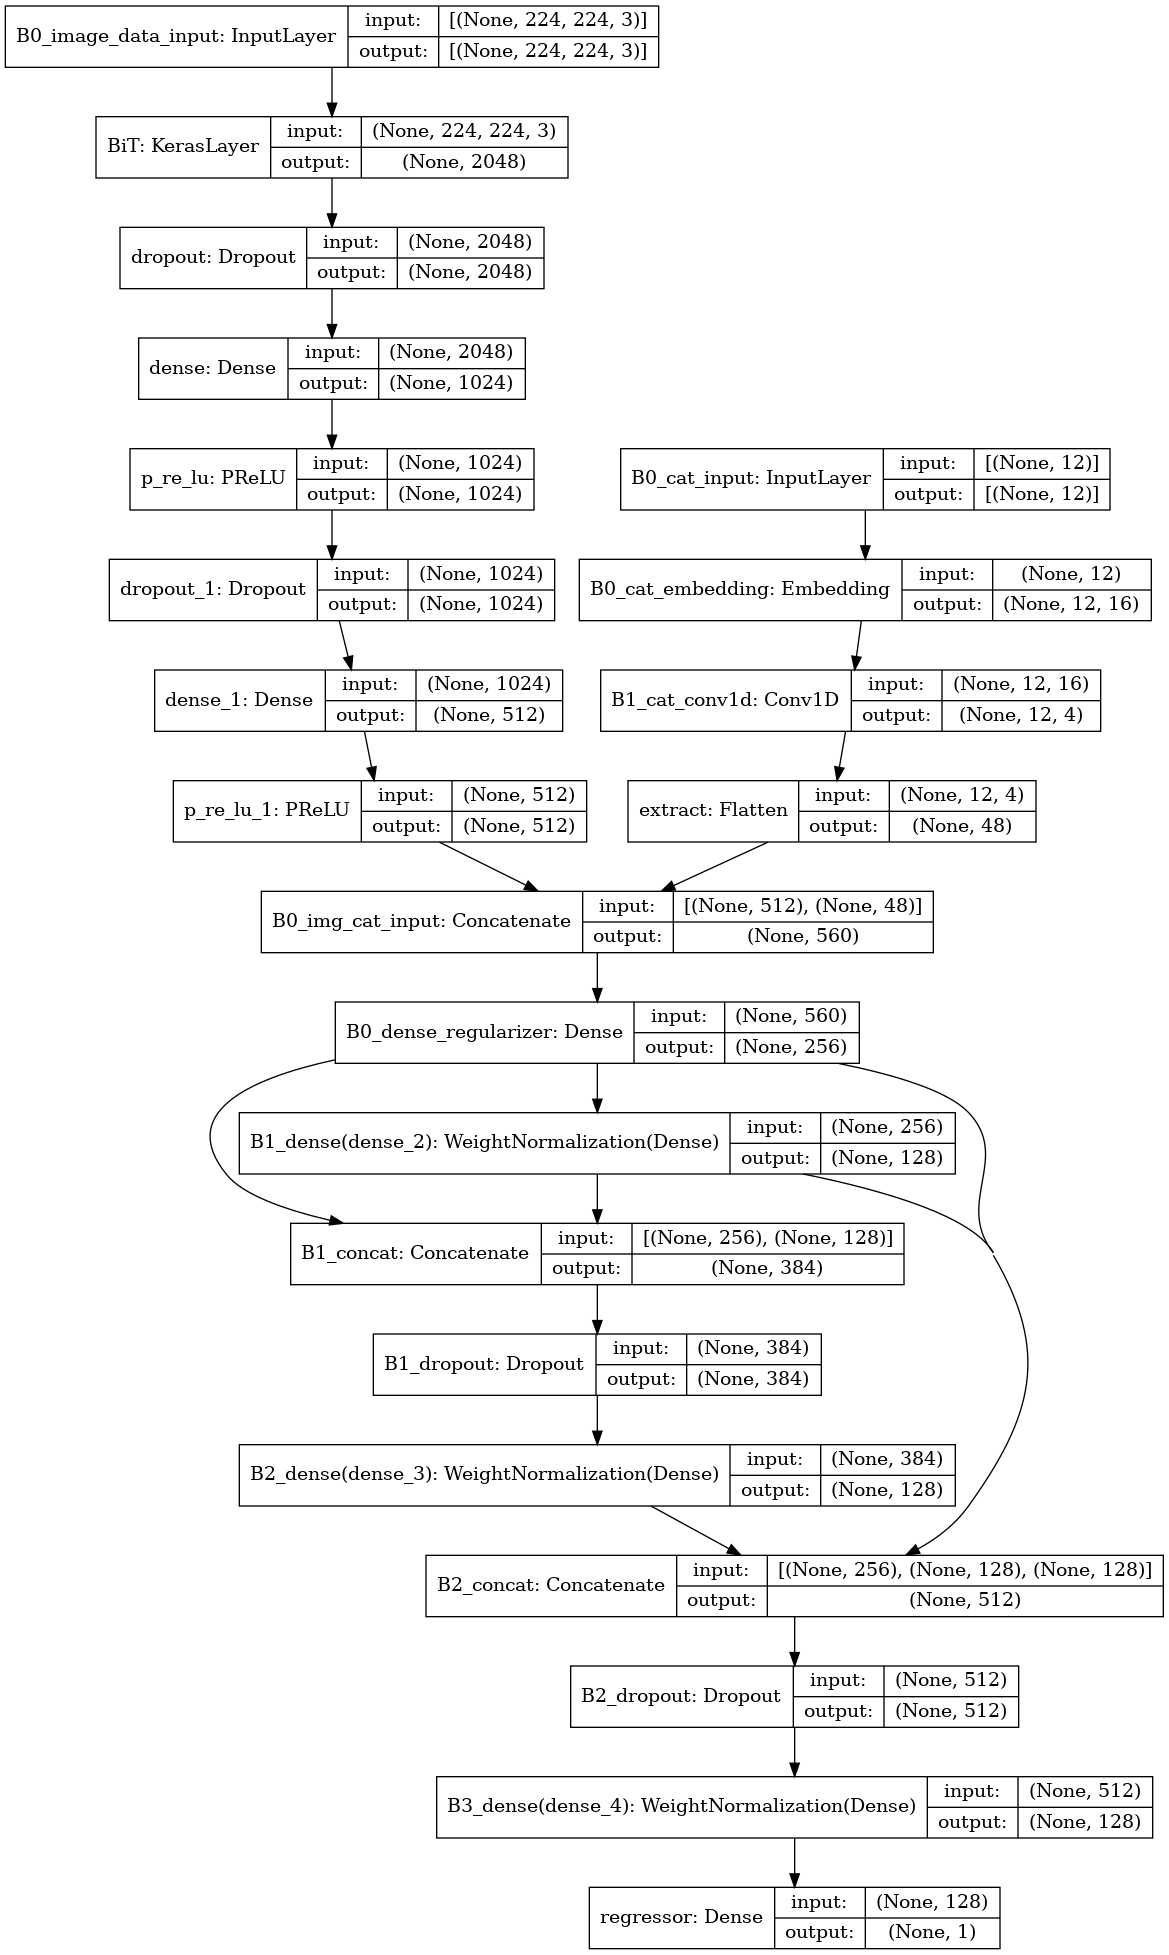

In [10]:
plot_model(createNN_ConcatLearning(createNN_image(), createNN_categoricalEmbedding()), show_shapes=True)

# 10-Folds Prediction

In [11]:
# learning parameter setting
epochs = 30
patient_epochs = 10
batch_size = 64
eta = 5e-4
weight_decay = 1e-3
model_name = "BiT_LP_Try1"
folder_path = "./"
wb_project_name = "kaggle_pawpularity"
checkpoint_filepath = './tmp_checkpoint/'

# fold spliter setting
kfolds_spliter = StratifiedKFold(10, random_state=4242, shuffle=True)
stratifed_vector = KBinsDiscretizer(10, strategy="quantile", encode="ordinal").fit_transform(full_y.to_frame()).flatten()

# result container setting
val_pred = {}
val_pred[model_name] = np.zeros((full_meta.shape[0],1))

test_pred = {}
test_pred[model_name] = np.zeros((test_meta.shape[0],1))

val_perf = {}
val_perf[model_name] = []

In [12]:
if os.path.isdir(checkpoint_filepath): shutil.rmtree(checkpoint_filepath)
seed_everything()
# fold training
for fold, (nonkIdx, kIdx) in enumerate(kfolds_spliter.split(full_meta, stratifed_vector)):
    print("\n===== Fold", fold+1, "=====\n")
    tf.keras.backend.clear_session()
    
#     fold_dir = "fold_" + str(fold)
#     log_dir = folder_path + "models/" + model_name + "/logs/" + fold_dir
#     if os.path.isdir(log_dir): shutil.rmtree(log_dir)
#     createFolder(log_dir)
#     tensorboard_callback = tf_callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
#     try:
#         wandb.tensorboard.patch(root_logdir=log_dir)
#     except:
#         pass
    
#     wandb.init(
#         project=wb_project_name,
#         name=fold_dir,
#         group=model_name
#     )

    print(F"1. {model_name}")
    tmp_time = time()
    train_ds = create_dataset(full_img.iloc[nonkIdx], full_meta.iloc[nonkIdx], full_y.iloc[nonkIdx],
                              batch_size=batch_size, augment=True, shuffle=True)
    val_ds = create_dataset(full_img.iloc[kIdx], full_meta.iloc[kIdx], full_y.iloc[kIdx],
                            batch_size=batch_size, augment=False, shuffle=False)
    test_ds = create_dataset(test_img, test_meta, None,
                             batch_size=batch_size, augment=False, shuffle=False)
    
    cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=1, factor=0.6, min_lr=1e-5)
    cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
    cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min',
                                                save_weights_only=True, save_best_only=True)

    model = createNN_ConcatLearning(createNN_image(), createNN_categoricalEmbedding())
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
        loss=copy.deepcopy(tf_loss_rmse),
        metrics=tf_metrics.RootMeanSquaredError(name="rmse")
    )
    model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
              callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, TqdmCallback(verbose=0)])
    model.load_weights(checkpoint_filepath)

    val_pred[model_name][kIdx] = model.predict(val_ds)
    val_perf[model_name].append(metrics.mean_squared_error(full_y.iloc[kIdx], val_pred[model_name][kIdx], squared=False))
    test_pred[model_name] += model.predict(test_ds) / kfolds_spliter.get_n_splits()

    print("Running Time --->", round(time() - tmp_time, 3),"sec")
    print(F"{model_name} Fold {fold+1} Performance ---> {val_perf[model_name][-1]}\n")
    print(F"{model_name} Average Performance ---> {np.mean(val_perf[model_name])}\n")
#     wandb.finish()
    shutil.rmtree(checkpoint_filepath)


===== Fold 1 =====

1. BiT_LP_Try1


0epoch [00:00, ?epoch/s]

Running Time ---> 2261.864 sec
BiT_LP_Try1 Fold 1 Performance ---> 18.72724311208412

BiT_LP_Try1 Average Performance ---> 18.72724311208412


===== Fold 2 =====

1. BiT_LP_Try1


0epoch [00:00, ?epoch/s]

Running Time ---> 2239.851 sec
BiT_LP_Try1 Fold 2 Performance ---> 18.475760781244468

BiT_LP_Try1 Average Performance ---> 18.601501946664293


===== Fold 3 =====

1. BiT_LP_Try1


0epoch [00:00, ?epoch/s]

Running Time ---> 2005.014 sec
BiT_LP_Try1 Fold 3 Performance ---> 17.91099663734487

BiT_LP_Try1 Average Performance ---> 18.371333510224485


===== Fold 4 =====

1. BiT_LP_Try1


0epoch [00:00, ?epoch/s]

Running Time ---> 2350.849 sec
BiT_LP_Try1 Fold 4 Performance ---> 18.47266086185134

BiT_LP_Try1 Average Performance ---> 18.396665348131197


===== Fold 5 =====

1. BiT_LP_Try1


0epoch [00:00, ?epoch/s]

Running Time ---> 1898.598 sec
BiT_LP_Try1 Fold 5 Performance ---> 18.396072778981857

BiT_LP_Try1 Average Performance ---> 18.39654683430133


===== Fold 6 =====

1. BiT_LP_Try1


0epoch [00:00, ?epoch/s]

Running Time ---> 2230.076 sec
BiT_LP_Try1 Fold 6 Performance ---> 18.262697433325062

BiT_LP_Try1 Average Performance ---> 18.374238600805285


===== Fold 7 =====

1. BiT_LP_Try1


0epoch [00:00, ?epoch/s]

Running Time ---> 2453.212 sec
BiT_LP_Try1 Fold 7 Performance ---> 18.371261037522412

BiT_LP_Try1 Average Performance ---> 18.373813234622016


===== Fold 8 =====

1. BiT_LP_Try1


0epoch [00:00, ?epoch/s]

Running Time ---> 2246.598 sec
BiT_LP_Try1 Fold 8 Performance ---> 18.063906149525344

BiT_LP_Try1 Average Performance ---> 18.335074848984934


===== Fold 9 =====

1. BiT_LP_Try1


0epoch [00:00, ?epoch/s]

Running Time ---> 2460.652 sec
BiT_LP_Try1 Fold 9 Performance ---> 18.55169977802876

BiT_LP_Try1 Average Performance ---> 18.35914428554536


===== Fold 10 =====

1. BiT_LP_Try1


0epoch [00:00, ?epoch/s]

Running Time ---> 2675.063 sec
BiT_LP_Try1 Fold 10 Performance ---> 19.15283181547331

BiT_LP_Try1 Average Performance ---> 18.438513038538154



In [13]:
# print("===== Meta Learning =====\n")
# for i in meta_learner.keys():
#     if i == "Linear":
#         meta_learner[i]["model"] = lm.LinearRegression(n_jobs=cpu_count())
#         meta_learner[i]["model"].fit(val_pred_x, full_y)
#         meta_learner[i]["val_pred"] = meta_learner[i]["model"].predict(val_pred_x)
#         meta_learner[i]["val_perf"] = metrics.mean_squared_error(full_y,  meta_learner[i]["val_pred"], squared=False)
#         meta_learner[i]["test_pred"] = meta_learner[i]["model"].predict(test_pred_x)
#         print("Linear RMSE :", meta_learner[i]["val_perf"])
#         print()
#     elif i == "MLP_1D":
#         meta_learner[i]["model"] = Sequential([
#             layers.Input(shape=(val_pred_x.shape[1])),
#             layers.Dense(8, use_bias=True, kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=0.0, max_value=1.0, rate=1.0)),
#             layers.Dense(1)
#         ])
#         epochs = 100
#         batch_size = 32
#         cb_earlystopping = tf_callbacks.EarlyStopping(monitor="rmse", patience=20, restore_best_weights=True)
#         cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=2, factor=0.8, min_lr=5e-4)
#         meta_learner[i]["model"].compile(optimizer=optimizers.Adam(learning_rate=eta), loss="mean_squared_error",
#                                          metrics=tf_metrics.RootMeanSquaredError(name="rmse"))
#         meta_learner[i]["model"].fit(val_pred_x, full_y, epochs=epochs, batch_size=batch_size, verbose=0,
#                                      callbacks=[cb_earlystopping, cb_reduceLR, TqdmCallback(verbose=0)])
#         meta_learner[i]["val_pred"] = meta_learner[i]["model"].predict(val_pred_x)[:,0]
#         meta_learner[i]["val_perf"] = metrics.mean_squared_error(full_y,  meta_learner[i]["val_pred"], squared=False)
#         meta_learner[i]["test_pred"] = meta_learner[i]["model"].predict(test_pred_x)[:,0]
#         print("MLP_1D RMSE :", meta_learner[i]["val_perf"])
#         print()

# Validation score summary

In [14]:
print("===== 10-Folds Average RMSE =====\n")
for k, v in val_perf.items():
    print(k, "--->", np.mean(v))

# print("\n\n===== Meta Learning Models RMSE =====\n")
# min_rmse_model = ("None", np.inf, [0])
# for k, v in meta_learner.items():
#     print(k, "--->", v["val_perf"])
#     if v["val_perf"] < min_rmse_model[1]:
#         min_rmse_model = (k, v["val_perf"], v["test_pred"])

===== 10-Folds Average RMSE =====

BiT_LP_Try1 ---> 18.438513038538154


# Submission

In [15]:
submission = read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")
submission.iloc[:,1] = test_pred[model_name].flatten()
submission.to_csv("./submission.csv", index=False)